In [12]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import glob
import pandas as pd
import os
import cartopy.crs as ccrs
import numpy as np

def spatial_mean(da):
    """Computes the spatial mean if lat and lon dimensions are present."""
    if 'lat' in da.dims and 'lon' in da.dims:
        return da.mean(dim=['lat', 'lon'])
    return da

# Convert cftime.DatetimeNoLeap to numpy.datetime64
def convert_time(ds):
    ds['time'] = [pd.Timestamp(time.strftime()) for time in ds['time'].values]
    return ds


# Study Urban PCT From Surface Data

In [4]:
fsurdat:str = "/home/jguo/projects/cesm/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_c190214.nc"
ds_sur = xr.open_mfdataset(fsurdat)


In [5]:
ds_sur


<xarray.Dataset>
Dimensions:                  (lsmlat: 192, lsmlon: 288, nlevsoi: 10,
                              natpft: 15, cft: 2, time: 12, lsmpft: 17,
                              numurbl: 3, numrad: 2, nlevurb: 5, nglcecp1: 11,
                              nglcec: 10)
Coordinates:
  * natpft                   (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft                      (cft) int32 15 16
  * time                     (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: lsmlat, lsmlon, nlevsoi, lsmpft, numurbl,
                                numrad, nlevurb, nglcecp1, nglcec
Data variables: (12/81)
    mxsoil_color             int32 ...
    SOIL_COLOR               (lsmlat, lsmlon) int32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    PCT_SAND                 (nlevsoi, lsmlat, lsmlon) float64 dask.array<chunksize=(10, 192, 288), meta=np.ndarray>
    PCT_CLAY                 (nlevsoi, lsmlat, lsmlon) float64 dask.array<chunksize=(10, 192, 288), meta=np.ndarray>
    ORGANIC                  (nlevsoi, lsmlat, lsmlon) float64 dask.array<chunksize=(10, 192, 288), meta=np.ndarray>
    FMAX                     (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    ...                       ...
    CONST_HARVEST_SH2        (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    CONST_HARVEST_SH3        (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    CONST_GRAZING            (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    CONST_FERTNITRO_CFT      (cft, lsmlat, lsmlon) float64 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    UNREPRESENTED_PFT_LULCC  (natpft, lsmlat, lsmlon) float64 dask.array<chunksize=(15, 192, 288), meta=np.ndarray>
    UNREPRESENTED_CFT_LULCC  (cft, lsmlat, lsmlon) float64 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                          NCAR-CSM
    History_Log:                          created on: 02-14-19 10:18:19
    Logname:                              erik
    Host:                                 cheyenne3
    Source:                               Community Land Model: CLM5
    Version:                              release-clm5.0.18/gpfs/fs1/scratch/...
    ...                                   ...
    map_vic_file:                         map_0.9x1.25_GRDC_to_0.9x1.25_nomas...
    Soil_texture_raw_data_file_name:      mksrf_soitex.10level.c010119.nc
    Soil_color_raw_data_file_name:        mksrf_soilcolor_CMIP6_simyr2005.c17...
    Fmax_raw_data_file_name:              mksrf_fmax_3x3min_USGS_c120911.nc
    Organic_matter_raw_data_file_name:    mksrf_organic_10level_5x5min_ISRIC-...
    Vegetation_type_raw_data_filename:    mksrf_landuse_histclm50_LUH2_2000.c...

In [ ]:


# Load the dataset
ds = xr.open_dataset(fsurdat)

# Access the PCT_URBAN variable
pct_urban = ds['PCT_URBAN']

In [ ]:
# https://bb.cgd.ucar.edu/cesm/threads/proportion-of-cities-in-surface-data.8046/
# PCT_URBAN is the percent of each urban density type. The density types in order are
# tall building district (TBD), high density (HD), and medium density (MD).
# If you change those percentages, e.g, increase them, then you'll need to decrease
# some other surface type (e.g., PCT_NATVEG, PCT_CROP, PCT_LAKE, etc.).
# The sum of PCT_URBAN, PCT_NATVEG, PCT_CROP, PCT_LAKE, PCT_GLACIER, PCT_WETLAND needs to be 100%.
# PCT_URBAN has multiple layers for different urban density types, sum across the 'numurbl' dimension to get total urban coverage
total_urban_pct = pct_urban.sum(dim='numurbl')

# Filter locations where total urban percentage is greater than 2%
# Using .where() to retain the data structure and metadata
masked_urban_areas = total_urban_pct.where(total_urban_pct > 0.02)

In [11]:
masked_urban_areas.count() /(192 * 288)


<xarray.DataArray 'PCT_URBAN' ()>
array(0.08297164)

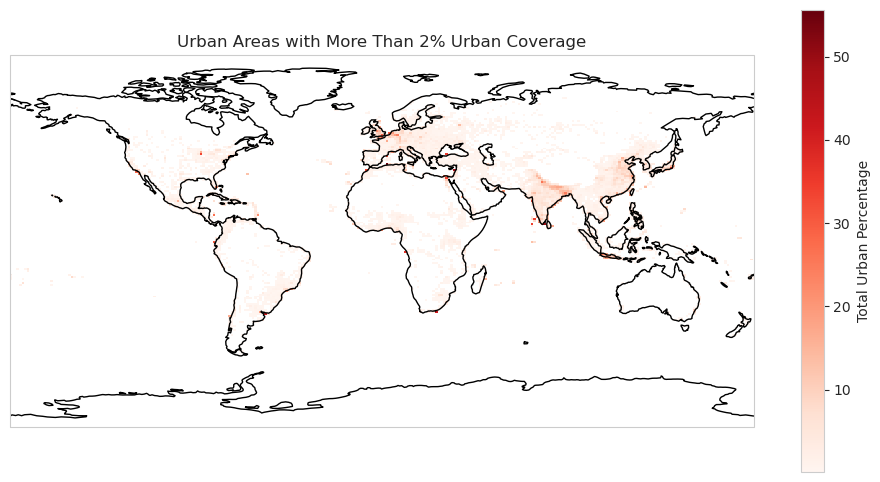

In [6]:

# Plotting
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Get longitude and latitude information from the dataset
longitude = ds['LONGXY']
latitude = ds['LATIXY']

# Plotting the urban areas that meet the condition
# Note: masked_urban_areas already has values below 2% filtered out, so we use it directly
plt.pcolormesh(longitude, latitude, masked_urban_areas, transform=ccrs.PlateCarree(), cmap='Reds')

plt.colorbar(label='Total Urban Percentage')
plt.title('Urban Areas with More Than 2% Urban Coverage')
plt.show()



In [7]:
masked_urban_areas

<xarray.DataArray 'PCT_URBAN' (lsmlat: 192, lsmlon: 288)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Dimensions without coordinates: lsmlat, lsmlon

In [14]:
masked_urban_areas.values.flatten()[~np.isnan(masked_urban_areas.values.flatten())][:10]
max_value, min_value = np.nanmax(masked_urban_areas.values), np.nanmin(masked_urban_areas.values)


# Use City Info from OpenStreetMap Overpass API to find the grid

In [ ]:
# Load city data
cities_df = pd.read_csv('Data/cities_info.csv')

# Filter cities with population greater than 50,000
cities_filtered = cities_df[cities_df['Population'] > 50000]

In [8]:


# Assuming the surface data is loaded into ds_sur and masked_urban_areas is already calculated

# Convert city coordinates to grid indices
# Assuming the grid starts at the minimum longitude and latitude in ds_sur
min_lon = ds_sur['LONGXY'].min()
min_lat = ds_sur['LATIXY'].min()

# Calculate grid indices for longitude and latitude
# The floor operation ensures the index aligns with the grid definition
cities_filtered['lon_idx'] = np.floor((cities_filtered['Lon'] - min_lon) / 1.25).astype(int)
cities_filtered['lat_idx'] = np.floor((cities_filtered['Lat'] - min_lat) / 0.9).astype(int)

# Update masked_urban_areas for each city
for lon_idx, lat_idx in zip(cities_filtered['lon_idx'], cities_filtered['lat_idx']):
    # Ensure indices are within bounds
    if 0 <= lon_idx < len(ds_sur['lsmlon']) and 0 <= lat_idx < len(ds_sur['lsmlat']):
        masked_urban_areas[lat_idx, lon_idx] = 1  # Or any other value indicating urban area

# Note: This approach uses minimal looping and relies more on vectorized operations for efficiency


<xarray.DataArray 'PCT_URBAN' (numurbl: 3, lsmlat: 192, lsmlon: 288)>
[165888 values with dtype=float64]
Dimensions without coordinates: numurbl, lsmlat, lsmlon
Attributes:
    long_name:  percent urban for each density type
    units:      unitless

In [9]:

# Filter locations where urban_pct is greater than 20%
urban_areas = urban_pct.where(urban_pct > 0.01)

urban_areas

<xarray.DataArray 'PCT_URBAN' (numurbl: 3, lsmlat: 192, lsmlon: 288)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Dimensions without coordinates: numurbl, lsmlat, lsmlon
Attributes:
    long_name:  percent urban for each density type
    units:      unitless

# Data Retrieval
    ## Select either Monethly (h0) daily (h1) or Hourly(h2) using wild card

In [23]:
# Directory where the netCDF files are located
data_directory = '/home/jguo/projects/cesm/archive/case/lnd/hist/'  # Current directory. Adjust this if your files are elsewhere.

# File pattern
# h0 is 20 years of 24 monthly files, each file contains just one monthly output  
file_pattern = "i.e215.I2000Clm50SpGs.hw_spinup.03.clm2.h0.*.nc"

file_path_pattern = os.path.join(data_directory, file_pattern)

## Get the list of files using the pattern

In [24]:
file_list = glob.glob(file_path_pattern)
file_list.sort(key=lambda x: os.path.basename(x).split('.')[-2])


In [25]:
# os.listdir(directory)
len(file_list)

240

## Open the files using Dask and Xarray

In [26]:
# List of variables to drop
drop_vars = ["ZSOI", "DZSOI", "WATSAT", "SUCSAT", "BSW", "HKSAT", "ZLAKE", "DZLAKE"]


In [27]:
# ds = xr.open_mfdataset(file_list, combine='by_coords', engine='netcdf4', chunks={'time': 480})
ds = xr.open_mfdataset(file_list, combine='by_coords', engine='netcdf4', drop_variables=drop_vars)

## Convert the cftime.DatetimeNoLeap objects to pandas Timestamps

In [28]:
#ds = convert_time(ds)

## examine the xarray object

In [29]:
ds

<xarray.Dataset>
Dimensions:                          (levgrnd: 25, levlak: 10, levdcmp: 1,
                                      time: 240, hist_interval: 2, lon: 288,
                                      lat: 192, levsoi: 20, cft: 2,
                                      glc_nec: 10, ltype: 9, natpft: 15,
                                      nvegwcs: 4)
Coordinates:
  * levgrnd                          (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levlak                           (levlak) float32 0.05 0.6 ... 34.33 44.78
  * levdcmp                          (levdcmp) float32 1.0
  * time                             (time) object 0001-02-01 00:00:00 ... 00...
  * lon                              (lon) float32 0.0 1.25 2.5 ... 357.5 358.8
  * lat                              (lat) float32 -90.0 -89.06 ... 89.06 90.0
Dimensions without coordinates: hist_interval, levsoi, cft, glc_nec, ltype,
                                natpft, nvegwcs
Data variables: (12/241)
    mcdate                           (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    mcsec                            (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    mdcur                            (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    mscur                            (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nstep                            (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bounds                      (time, hist_interval) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...                               ...
    WBT_R                            (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    WBT_U                            (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    WIND                             (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    ZBOT                             (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    ZWT                              (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    ZWT_PERCH                        (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 01/25/24 01:04:41
    source:                                    Community Land Model CLM4.0
    hostname:                                  JohnnyThinkStation
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1

# Convert K to C for TBOT

In [30]:
ds['TBOT_C'] = ds['TBOT'] - 273.15

# Update the attributes for the new variable to reflect the change in units
ds['TBOT_C'].attrs['units'] = 'C'
ds['TBOT_C'].attrs['long_name'] = '2m air temperature in Celsius'

# Weighting and Averaging


## Area Weighted


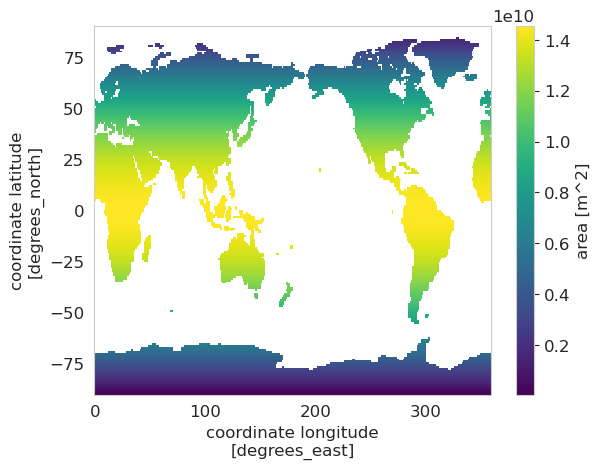

In [31]:
#pure land portion weight
#la = (ds.landfrac*ds.area).isel(time=0).drop(['time'])
#just area weight
la = (ds.area).isel(time=0).drop(['time'])
# the unit should not matter in the context of calculating weight
la = la * 1e6  #converts from land area from km2 to m2 
la.attrs['units'] = 'm^2'
lw = la
lw.plot() 

In [32]:
lw.sum().values

array(1.6694878e+14, dtype=float32)

In [33]:
def compute_weighted_avg_vectorized(ds, lw):
    # Normalize the area weights to sum to 1
    lw_normalized = lw / lw.sum(dim=['lat', 'lon'])

    # Filter the dataset to include only data variables with 'lat' and 'lon' dimensions
    data_vars_with_latlon = {name: var for name, var in ds.data_vars.items() if {'lat', 'lon'}.issubset(var.dims)}

    # Use the filtered data variables to create a new dataset
    ds_with_latlon = xr.Dataset(data_vars_with_latlon)

    # Perform the vectorized operation of multiplying each variable by the area weights
    weighted_ds = ds_with_latlon * lw_normalized

    # Sum over the 'lat' and 'lon' dimensions to get the weighted average
    weighted_avg_ds = weighted_ds.sum(dim=['lat', 'lon'])

    return weighted_avg_ds

# Call the function with the dataset and land weights
weighted_avg_dataset = compute_weighted_avg_vectorized(ds, lw)

# weighted_avg_dataset now contains the weighted averages for each variable


## yearly avg, the resample command is important and cool

In [34]:

yearly_avg = weighted_avg_dataset.resample(time='AS-FEB').mean()

In [35]:
yearly_avg
#print(yearly_avg.time[0])

<xarray.Dataset>
Dimensions:                          (time: 20, levsoi: 20, cft: 2,
                                      glc_nec: 10, ltype: 9, natpft: 15,
                                      levgrnd: 25, levlak: 10, nvegwcs: 4)
Coordinates:
  * levgrnd                          (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levlak                           (levlak) float32 0.05 0.6 ... 34.33 44.78
  * time                             (time) object 0001-02-01 00:00:00 ... 00...
Dimensions without coordinates: levsoi, cft, glc_nec, ltype, natpft, nvegwcs
Data variables: (12/234)
    area                             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    landfrac                         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    landmask                         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    pftmask                          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nbedrock                         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ATM_TOPO                         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                               ...
    WBT_U                            (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    WIND                             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ZBOT                             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ZWT                              (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ZWT_PERCH                        (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    TBOT_C                           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

# Define Variables to Report

In [36]:
variables = ['TBOT_C', 'QBOT', 'RAIN', 'EFLX_LH_TOT', 'FSH']

In [37]:
# Calculate spatial average for each variable
for var in variables:
    yearly_avg[var] = spatial_mean(yearly_avg[var])


# Convert time axis to integer year

In [38]:
yearly_avg = yearly_avg.assign_coords(time=yearly_avg.time.dt.year)

In [39]:
print(yearly_avg)

<xarray.Dataset>
Dimensions:                          (time: 20, levsoi: 20, cft: 2,
                                      glc_nec: 10, ltype: 9, natpft: 15,
                                      levgrnd: 25, levlak: 10, nvegwcs: 4)
Coordinates:
  * levgrnd                          (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levlak                           (levlak) float32 0.05 0.6 ... 34.33 44.78
  * time                             (time) int64 1 2 3 4 5 6 ... 16 17 18 19 20
Dimensions without coordinates: levsoi, cft, glc_nec, ltype, natpft, nvegwcs
Data variables: (12/234)
    area                             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    landfrac                         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    landmask                         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    pftmask                          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nbedrock                

# Plot time series of yearly average

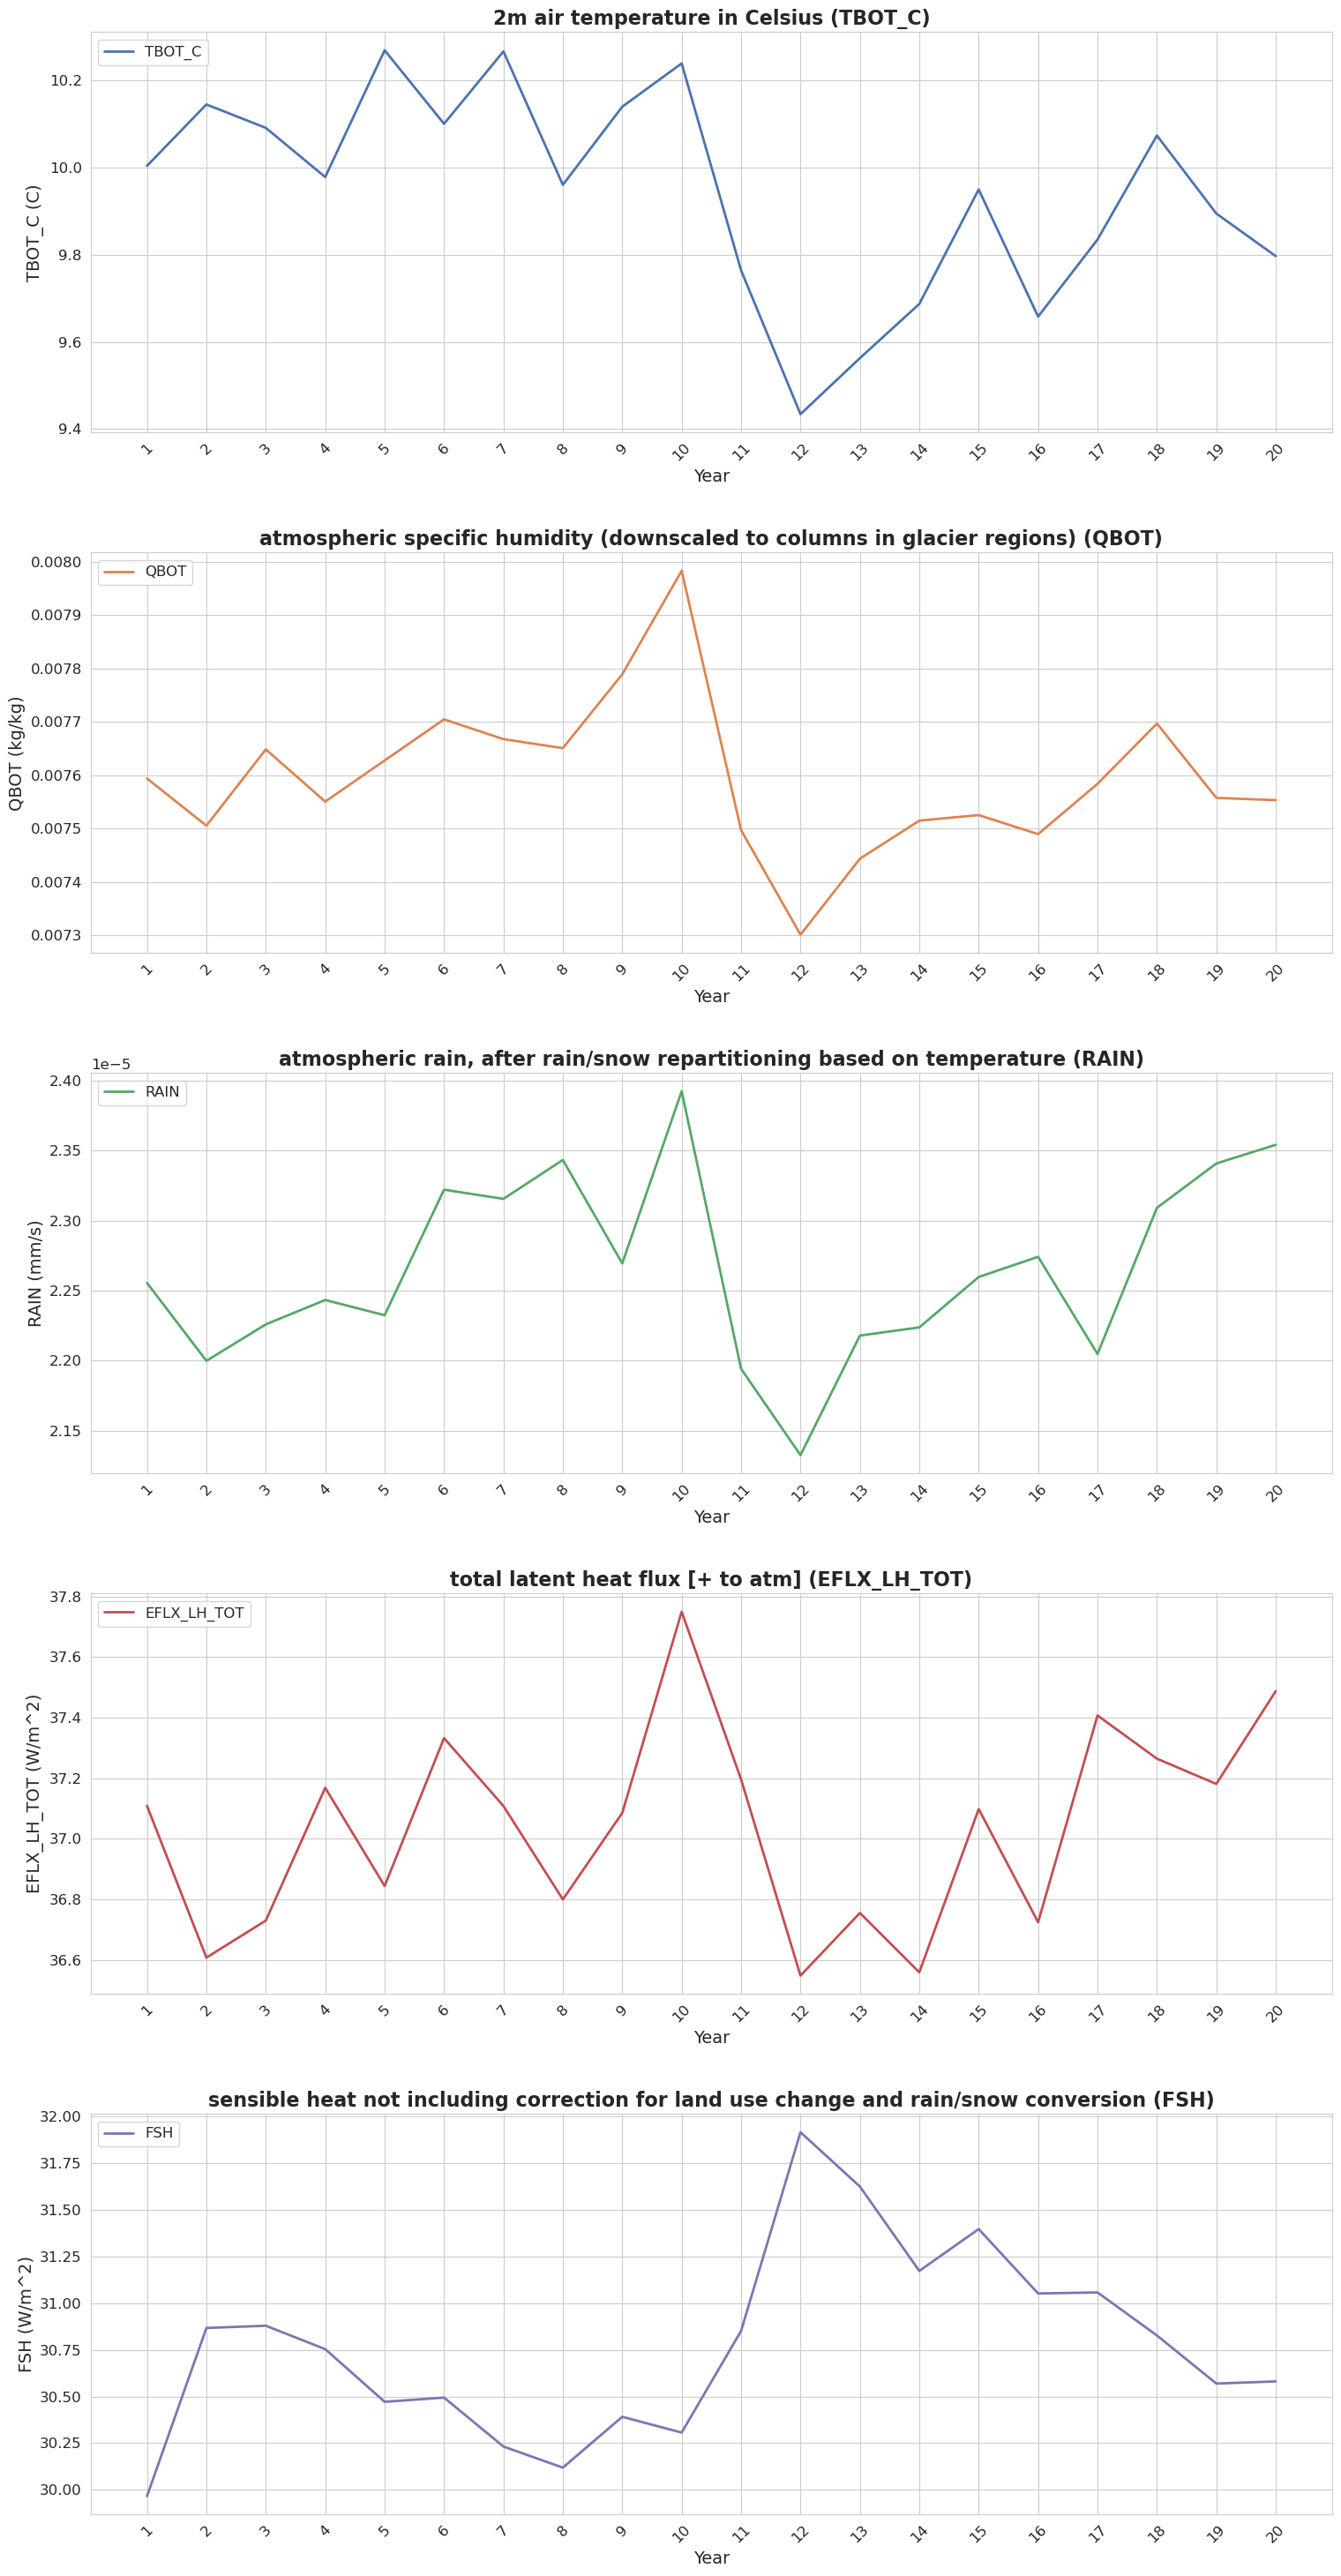

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")  # Use seaborn's whitegrid style
plt.rcParams['font.size'] = 12  # Increase default font size

# Assuming 'yearly_avg' is your data and 'variables' is a list of variable names you want to plot
# Create subplots for each variable
fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize=(16, 6 * len(variables)))

# Ensure 'axes' is an array even with a single subplot
if len(variables) == 1:
    axes = [axes]

colors = sns.color_palette("deep", len(variables))  # A palette of distinct colors for each variable

for ax, var, color in zip(axes, variables, colors):
    ax.plot(yearly_avg['time'], yearly_avg[var], label=var, color=color, linewidth=2)

    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel(f'{var} ({ds[var].attrs.get("units", "unknown units")})', fontsize=14)  # Retrieving units from dataset attributes

    # Fetching long_name from attributes and forming the title
    long_name = ds[var].attrs.get('long_name', var)  # Using var as default if long_name is absent
    ax.set_title(f'{long_name} ({var})', fontsize=16, fontweight='bold')

    ax.legend(loc='upper left')

    # Set x-axis ticks to show each year
    ax.set_xticks(yearly_avg['time'])  # Set ticks at each year in the 'time' array
    ax.set_xticklabels(yearly_avg['time'].values, rotation=45)  # Set tick labels to show the year, rotating for readability

plt.tight_layout(pad=3)  # Adjust padding
plt.show()
